In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, SpatialDropout1D, Dropout, Bidirectional, BatchNormalization, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import re

In [2]:
df=pd.read_csv(r"C:\Users\Arnav\Desktop\DLM Dataset.csv")
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,24-02-2015 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,24-02-2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,24-02-2015 11:14,NaN,Pacific Time (US & Canada)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,5.695880e+17,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,22-02-2015 12:01,NaN,NaN
14636,5.695870e+17,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,22-02-2015 11:59,Texas,NaN
14637,5.695870e+17,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,22-02-2015 11:59,"Nigeria,lagos",NaN
14638,5.695870e+17,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,22-02-2015 11:59,New Jersey,Eastern Time (US & Canada)


In [3]:
df = df[['airline_sentiment', 'negativereason', 'airline', 'airline_sentiment_gold', 'negativereason_gold', 'text', 'tweet_created']].copy()
df.dropna(subset=['text'], inplace=True)  

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # Remove links
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

In [38]:
print("Dataset Overview:")
print(df.describe(include='all'))
print("\nSentiment Value Counts:")
print(df['airline_sentiment'].value_counts())

Dataset Overview:
       airline_sentiment          negativereason airline  \
count              14640                    9178   14640   
unique                 3                      10       6   
top             negative  Customer Service Issue  United   
freq                9178                    2910    3822   
mean                 NaN                     NaN     NaN   
std                  NaN                     NaN     NaN   
min                  NaN                     NaN     NaN   
25%                  NaN                     NaN     NaN   
50%                  NaN                     NaN     NaN   
75%                  NaN                     NaN     NaN   
max                  NaN                     NaN     NaN   

       airline_sentiment_gold     negativereason_gold            text  \
count                      40                      32           14640   
unique                      3                      13           14427   
top                  negative  Customer Se

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


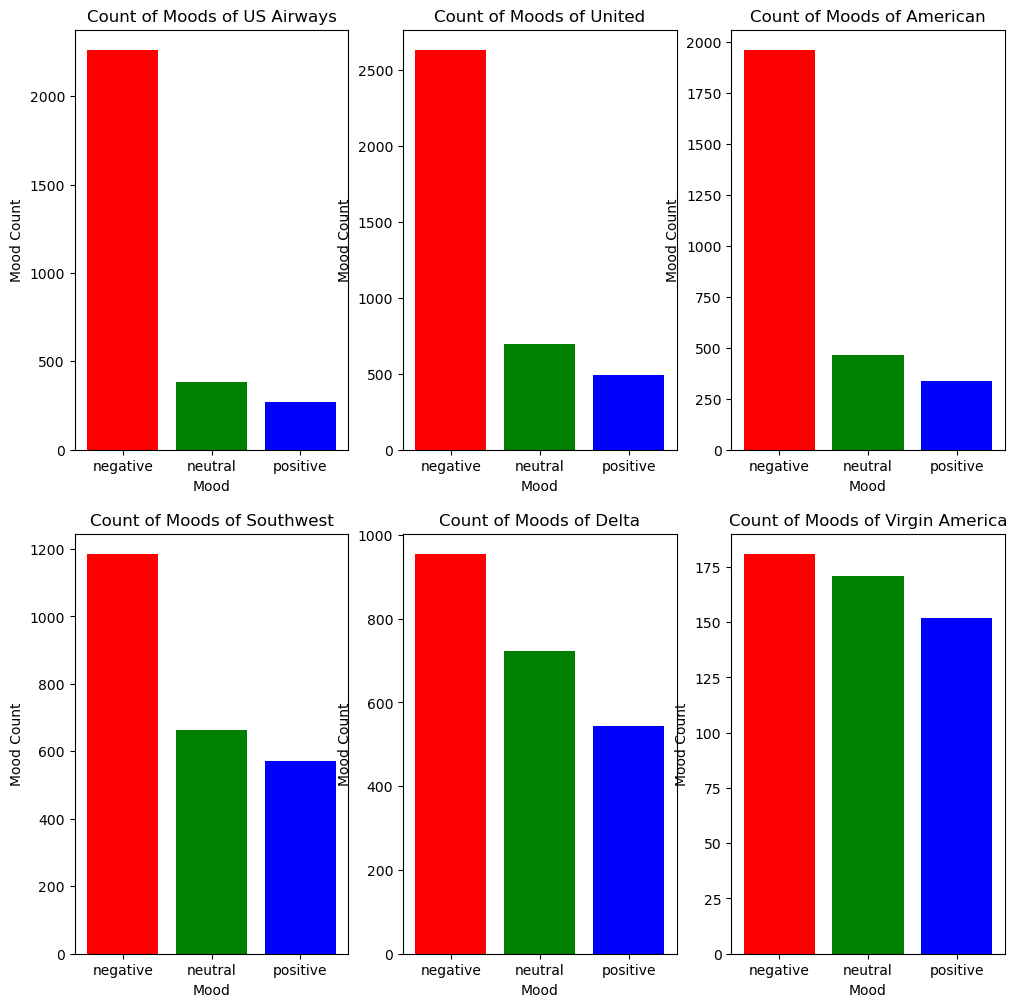

In [31]:
print("Total number of tweets for each airline \n ",df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=df[df['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

C:\Users\Arnav\AppData\Local\Temp\ipykernel_19360\2219542597.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='airline_sentiment', palette='Set2')


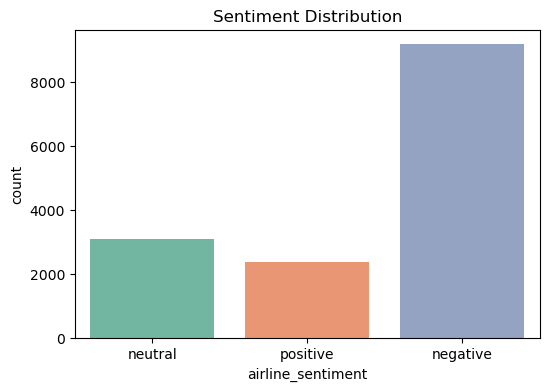

In [22]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='airline_sentiment', palette='Set2')
plt.title('Sentiment Distribution')
plt.show()

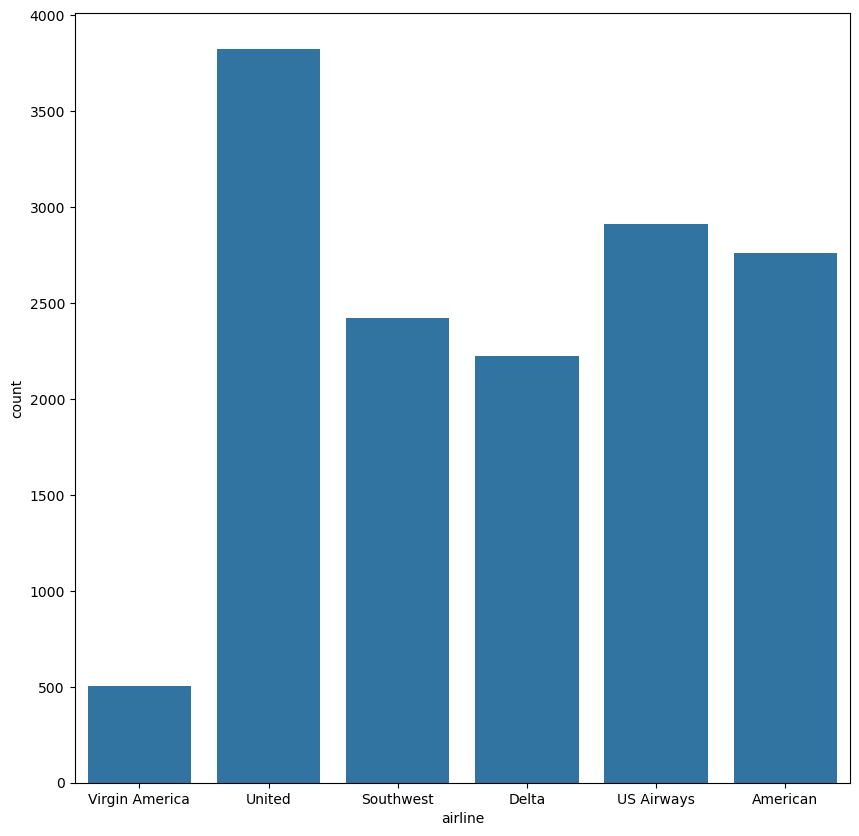

In [30]:
plt.figure(figsize=(10,10))
ax = sns.countplot(x="airline", data=df)

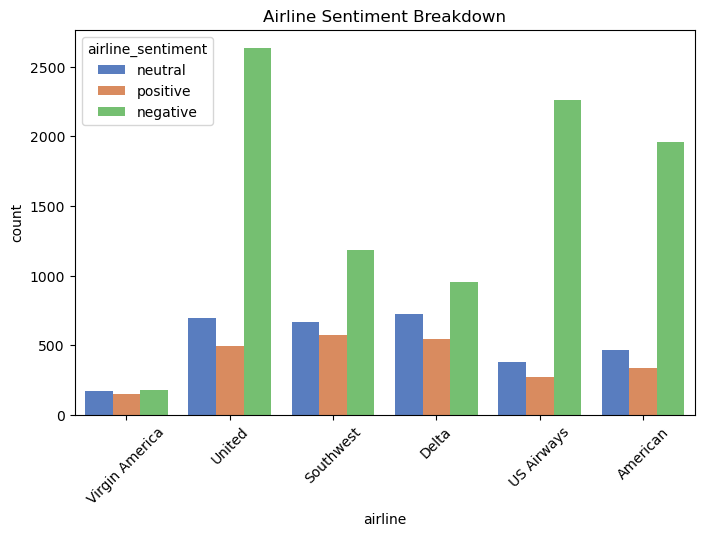

In [26]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='airline', hue='airline_sentiment', palette='muted')
plt.title('Airline Sentiment Breakdown')
plt.xticks(rotation=45)
plt.show()

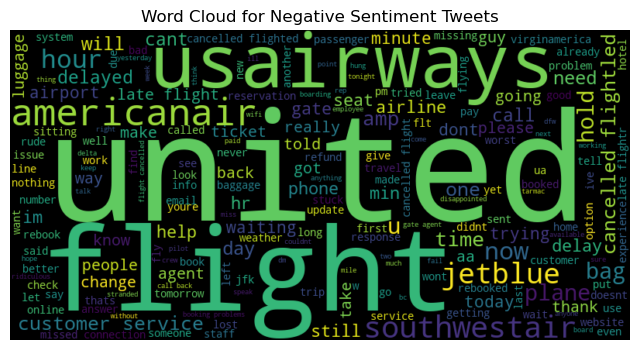

In [34]:
negative_tweets = ' '.join(df[df['airline_sentiment'] == 'negative']['cleaned_text'])
plt.figure(figsize=(8, 5))
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_tweets)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Sentiment Tweets')
plt.show()

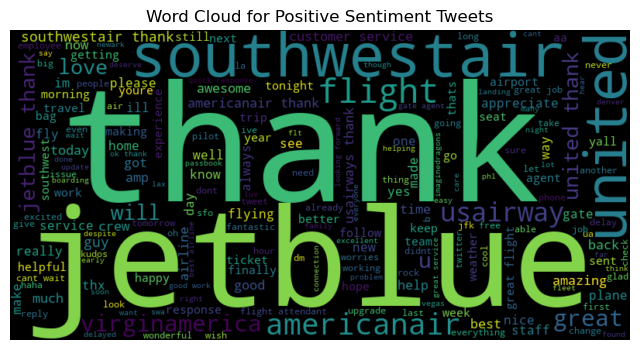

In [37]:
negative_tweets = ' '.join(df[df['airline_sentiment'] == 'positive']['cleaned_text'])
plt.figure(figsize=(8, 5))
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_tweets)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment Tweets')
plt.show()

C:\Users\Arnav\AppData\Local\Temp\ipykernel_19360\3997449335.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='negativereason', order=df['negativereason'].value_counts().index, palette='Reds')


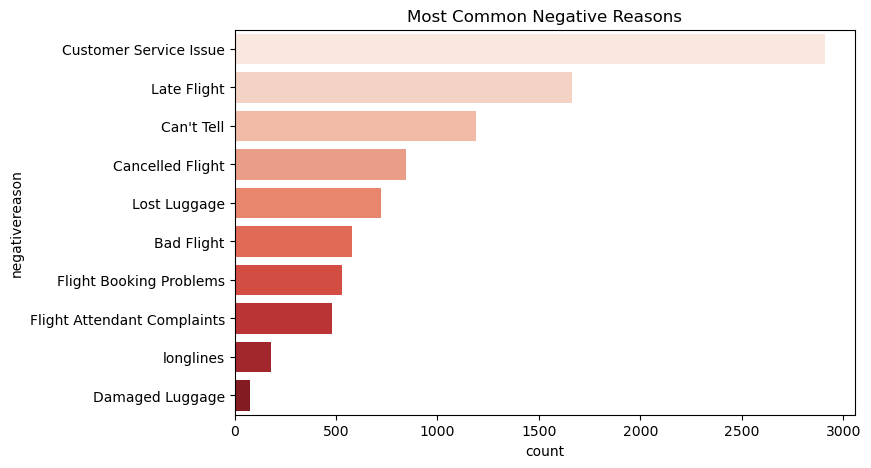

In [23]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, y='negativereason', order=df['negativereason'].value_counts().index, palette='Reds')
plt.title('Most Common Negative Reasons')
plt.show()

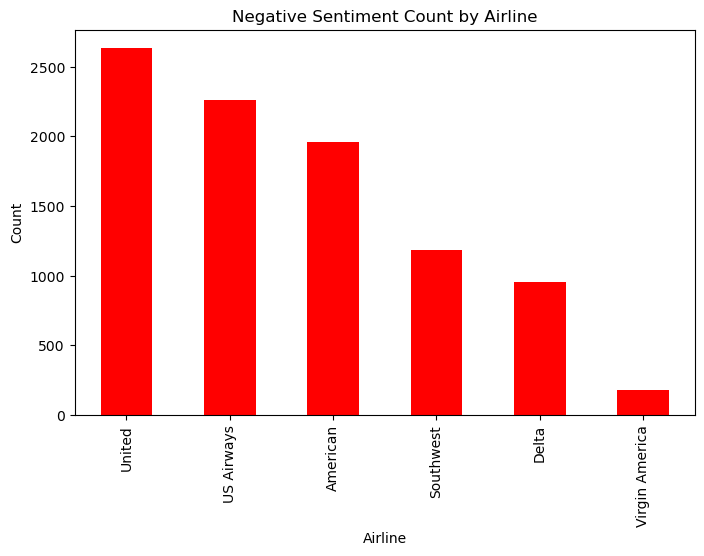

In [27]:
plt.figure(figsize=(8, 5))
negative_airlines = df[df['airline_sentiment'] == 'negative']['airline'].value_counts()
negative_airlines.plot(kind='bar', color='red')
plt.title('Negative Sentiment Count by Airline')
plt.xlabel('Airline')
plt.ylabel('Count')
plt.show()

C:\Users\Arnav\AppData\Local\Temp\ipykernel_19360\1588921537.py:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['tweet_created'] = pd.to_datetime(df['tweet_created'])


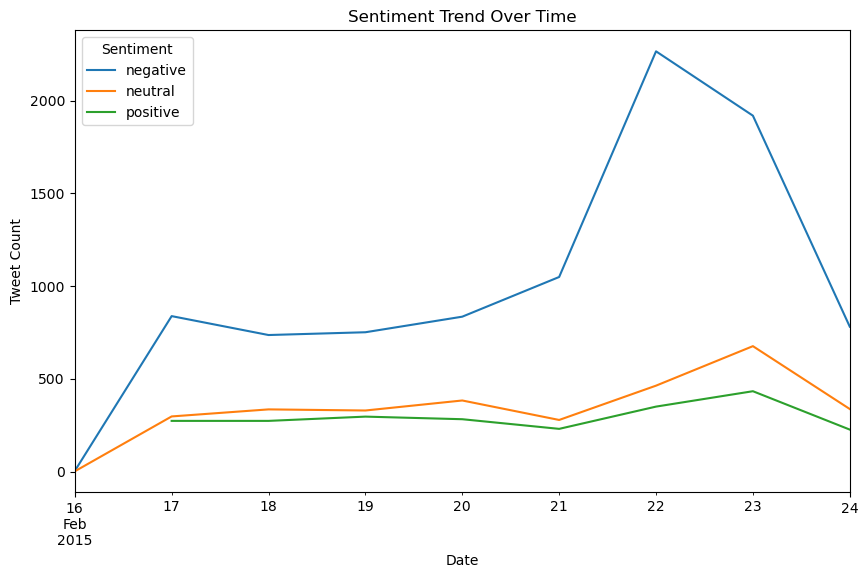

In [28]:
df['tweet_created'] = pd.to_datetime(df['tweet_created'])
df.set_index('tweet_created', inplace=True)
df.resample('D')['airline_sentiment'].value_counts().unstack().plot(kind='line', figsize=(10, 6))
plt.title('Sentiment Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Tweet Count')
plt.legend(title='Sentiment')
plt.show()

In [7]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['cleaned_text'])

X = tokenizer.texts_to_sequences(df['cleaned_text'])
X = pad_sequences(X, maxlen=50, padding='post')

In [8]:
df['sentiment_encoded'] = df['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
y = df['sentiment_encoded'].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=50))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

C:\Users\Arnav\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [12]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [14]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 39s 175ms/step - accuracy: 0.6310 - loss: 0.8844 - val_accuracy: 0.7176 - val_loss: 0.6651
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.7408 - loss: 0.6139 - val_accuracy: 0.7679 - val_loss: 0.5818
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 27s 165ms/step - accuracy: 0.8090 - loss: 0.4924 - val_accuracy: 0.7961 - val_loss: 0.5198
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 156ms/step - accuracy: 0.8500 - loss: 0.4083 - val_accuracy: 0.8123 - val_loss: 0.4956
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.8783 - loss: 0.3370 - val_accuracy: 0.8157 - val_loss: 0.5179
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 160ms/step - accuracy: 0.8980 - loss: 0.2950 - val_accuracy: 0.7935 - val_loss: 0.5464
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - accuracy: 0.9034 - loss: 0.2656 - val_accuracy: 0.8055 - val_loss: 0.5632


In [15]:
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1889
           1       0.59      0.62      0.60       580
           2       0.73      0.69      0.71       459

    accuracy                           0.80      2928
   macro avg       0.73      0.73      0.73      2928
weighted avg       0.80      0.80      0.80      2928



In [16]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy:.2%}')

Model Accuracy: 79.82%


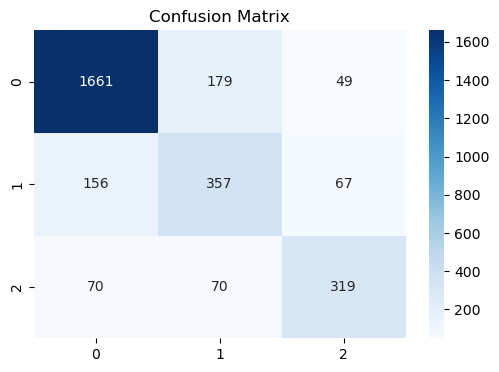

In [17]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [18]:
def test_model(input_text):
    cleaned_text = clean_text(input_text)
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(seq, maxlen=50, padding='post')
    prediction = model.predict(padded)
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    return sentiment_labels[np.argmax(prediction)]

In [19]:
example_tweet = "The flight experience was absolutely terrible!"
print(f"Test Example Prediction: {test_model(example_tweet)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Test Example Prediction: Negative


In [20]:
example_tweet = "The flight experience was wonderful!"
print(f"Test Example Prediction: {test_model(example_tweet)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Test Example Prediction: Positive


In [21]:
example_tweet = "Air conditioners were not working!"
print(f"Test Example Prediction: {test_model(example_tweet)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Test Example Prediction: Negative
